## Tags Distribution

Notebook plots distribution of image tags  

**Input**:
- Source Project

**Output**:
- Plot distribution

## Configuration

Edit the following settings for your own case

In [10]:
%matplotlib inline

In [11]:
import supervisely_lib as sly
import os
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [15]:
team_name = "jupyter_tutorials"
workspace_name = "cookbook"
project_name = "lemons_annotated_01"

# Obtain server address and your api_token from environment variables
# Edit those values if you run this notebook on your own PC
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

In [16]:
# Initialize API object
api = sly.Api(address, token)

## Verify input values

Test that context (team / workspace / project) exists

In [17]:
# Get IDs of team, workspace and project by names

team = api.team.get_info_by_name(team_name)
if team is None:
    raise RuntimeError("Team {!r} not found".format(team_name))

workspace = api.workspace.get_info_by_name(team.id, workspace_name)
if workspace is None:
    raise RuntimeError("Workspace {!r} not found".format(workspace_name))
    
project = api.project.get_info_by_name(workspace.id, project_name)
if project is None:
    raise RuntimeError("Project {!r} not found".format(project_name))
    
print("Team: id={}, name={}".format(team.id, team.name))
print("Workspace: id={}, name={}".format(workspace.id, workspace.name))
print("Project: id={}, name={}".format(project.id, project.name))

Team: id=30, name=jupyter_tutorials
Workspace: id=76, name=cookbook
Project: id=1130, name=lemons_annotated_01


## Get Source ProjectMeta

In [18]:
project = api.project.get_info_by_name(workspace.id, project_name)
meta_json = api.project.get_meta(project.id)
meta = sly.ProjectMeta.from_json(meta_json)
print("Source ProjectMeta: \n", meta)

Source ProjectMeta: 
 ProjectMeta:
Object Classes
+-------+-----------+-----------------+
|  Name |   Shape   |      Color      |
+-------+-----------+-----------------+
|   bg  | Rectangle | [153, 245, 169] |
|  kiwi |   Bitmap  |   [255, 0, 0]   |
| lemon |   Bitmap  |  [81, 198, 170] |
+-------+-----------+-----------------+
Image Tags
+-------+------------+-----------------+
|  Name | Value type | Possible values |
+-------+------------+-----------------+
|  val  |    none    |       None      |
| train |    none    |       None      |
+-------+------------+-----------------+
Object Tags
+------+------------+-----------------+
| Name | Value type | Possible values |
+------+------------+-----------------+
+------+------------+-----------------+



In [19]:
tags_counter = defaultdict(int)
tags_counter_without_sdk = defaultdict(int)

for dataset in api.dataset.get_list(project.id):
    print('Dataset: {}'.format(dataset.name))
    for image in tqdm(api.image.get_list(dataset.id)):
        ann_json = api.annotation.download(image.id).annotation
        ann = sly.Annotation.from_json(ann_json, meta)
        
        # count tags using SDK
        for tag in ann.img_tags:
            tags_counter[tag.meta.name] += 1 
        
        # count tags using raw JSON annotation
        for tag in ann_json["tags"]:
            if type(tag) is str:
                name = tag
            else:
                name = tag["name"]
            tags_counter_without_sdk[name] += 1 

  7%|▋         | 5/72 [00:00<00:01, 47.46it/s]

Dataset: ds1


100%|██████████| 72/72 [00:01<00:00, 49.72it/s]


## Distribution (using SDK)

[('train', 63), ('val', 9)]


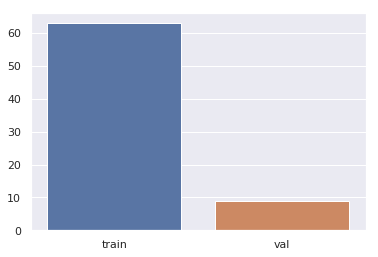

In [20]:
sorted_list = sorted(tags_counter.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_list)
x = [item[0] for item in sorted_list]
y = [item[1] for item in sorted_list]
ax = sns.barplot(x=x, y=y)

## Distribution (using raw JSON data - for debug purposes)

[('train', 63), ('val', 9)]


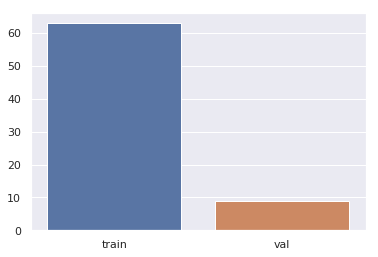

In [21]:
sorted_list = sorted(tags_counter_without_sdk.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_list)
x = [item[0] for item in sorted_list]
y = [item[1] for item in sorted_list]
ax = sns.barplot(x=x, y=y)

# Done!